In [1]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 55.3 MB/s eta 0:00:00


In [2]:
from IPython import get_ipython
from IPython.display import display
import matplotlib.patches as mpatches
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_circles
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


In [3]:
# Generate concentric circles dataset
X, Y = make_circles(n_samples=100, noise=0.05, factor=0.5)
scaler = MinMaxScaler()
X = scaler.fit_transform(X) * np.pi  # scale features to [0, pi]

In [4]:
# Print dataset points and labels
print("Dataset points (X):")
print(X)
print("\nDataset labels (Y):")
print(Y)

Dataset points (X):
[[2.23146995 1.61160796]
 [0.81594434 1.79758314]
 [1.47586191 2.24464463]
 [1.26056604 1.09639116]
 [0.23673334 1.12283294]
 [2.29228667 1.31173994]
 [0.90670712 1.7900096 ]
 [0.33657618 2.53431395]
 [1.10803648 1.02759201]
 [2.04905101 0.99969803]
 [2.2427178  2.84555038]
 [3.01031864 1.89877304]
 [0.77634631 1.75394468]
 [1.90664363 0.92382239]
 [1.48460381 0.80817637]
 [2.97432156 1.63427005]
 [2.18742435 0.30170147]
 [2.61052099 0.66259021]
 [1.24603198 0.25850754]
 [1.2276916  2.13623888]
 [2.56433369 0.51601877]
 [0.78878509 1.47612164]
 [0.         1.72146265]
 [0.92104427 1.25466274]
 [0.87821857 1.53458392]
 [0.52684116 0.40360853]
 [2.89784286 0.87347434]
 [1.98155522 2.1465279 ]
 [1.49743244 2.31857056]
 [1.94438494 2.22896065]
 [2.3593517  1.60983866]
 [1.58267666 1.01020312]
 [2.29145662 1.46943314]
 [2.92252914 1.26532649]
 [2.92692919 2.10246896]
 [0.44695188 2.31044152]
 [1.9810946  2.25961104]
 [1.21763079 0.22634444]
 [2.66767331 0.86187345]
 [2.1

In [5]:
# Classical ML baseline: Logistic Regression
clf = LogisticRegression()
clf.fit(X, Y)
Y_pred_classical = clf.predict(X)
acc_classical = accuracy_score(Y, Y_pred_classical)
print("Classical ML Accuracy (Logistic Regression):", acc_classical)

Classical ML Accuracy (Logistic Regression): 0.5


In [6]:
# QML Setup
dev = qml.device("default.qubit", wires=2)

In [7]:
def feature_map(x):
    qml.RX(x[0], wires=0)
    qml.RX(x[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(x[0], wires=1)
    qml.RY(x[1], wires=0)

In [8]:
def variational_layer(weights):
    qml.RY(weights[0], wires=0)
    qml.RY(weights[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RZ(weights[2], wires=1)

In [9]:
@qml.qnode(dev)
def circuit(x, weights):
    feature_map(x)
    variational_layer(weights)
    return qml.expval(qml.PauliZ(0))

In [10]:
def variational_classifier(weights, x):
    return circuit(x, weights)

In [11]:
def cost(weights, X, Y):
    predictions = [variational_classifier(weights, x) for x in X]
    predictions = np.array(predictions, dtype=np.float64)
    labels = np.array(2 * Y - 1, dtype=np.float64)  # convert {0,1} to {-1,1}
    return np.mean((predictions - labels)**2)

In [12]:
# Training QML model
np.random.seed(42)
weights = np.random.randn(3, requires_grad=True)
opt = qml.GradientDescentOptimizer(stepsize=0.3)

epochs = 50
for i in range(epochs):
    weights = opt.step(lambda w: cost(w, X, Y), weights)
    if (i + 1) % 10 == 0:
        preds = [variational_classifier(weights, x) for x in X]
        preds = np.array(preds, dtype=np.float64)
        pred_labels = [1 if p > 0 else 0 for p in preds]
        acc_qml = accuracy_score(Y, pred_labels)
        print(f"Epoch {i+1}: QML Accuracy = {acc_qml:.2f}")

Epoch 10: QML Accuracy = 0.49
Epoch 20: QML Accuracy = 0.48
Epoch 30: QML Accuracy = 0.50
Epoch 40: QML Accuracy = 0.50
Epoch 50: QML Accuracy = 0.47


Final QML Accuracy: 0.47


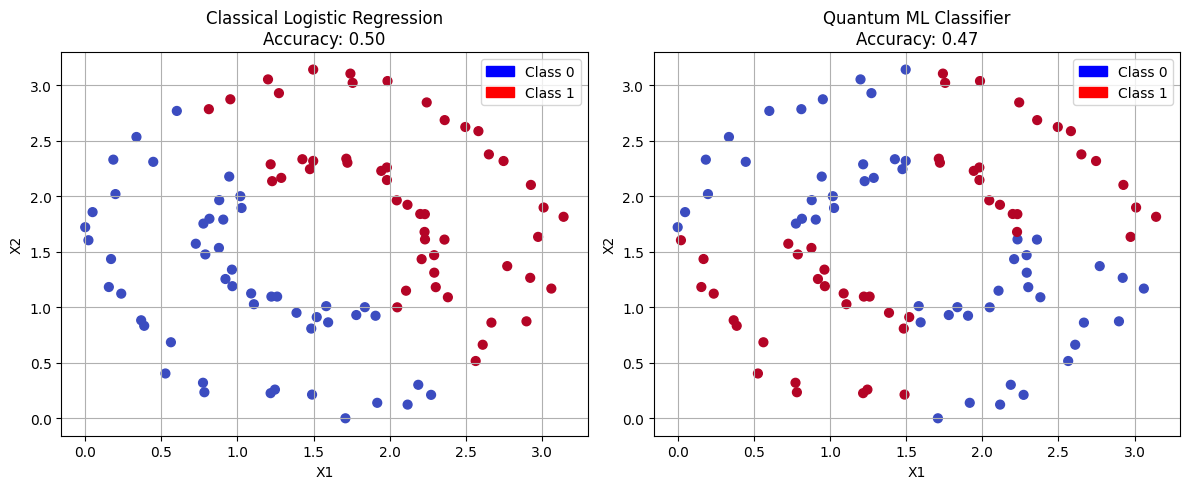

In [13]:
# Final QML accuracy and predictions
preds = [variational_classifier(weights, x) for x in X]
preds = np.array(preds, dtype=np.float64)
pred_labels_qml = [1 if p > 0 else 0 for p in preds]
acc_qml = accuracy_score(Y, pred_labels_qml)
print("Final QML Accuracy:", acc_qml)

# Plot predictions for classical ML and QML side-by-side


# Define legend patches
blue_patch = mpatches.Patch(color='blue', label='Class 0')
red_patch = mpatches.Patch(color='red', label='Class 1')

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sc1 = axs[0].scatter(X[:, 0], X[:, 1], c=Y_pred_classical, cmap='coolwarm', s=40)
axs[0].set_title(f"Classical Logistic Regression\nAccuracy: {acc_classical:.2f}")
axs[0].set_xlabel("X1")
axs[0].set_ylabel("X2")
axs[0].grid(True)
axs[0].legend(handles=[blue_patch, red_patch])

sc2 = axs[1].scatter(X[:, 0], X[:, 1], c=pred_labels_qml, cmap='coolwarm', s=40)
axs[1].set_title(f"Quantum ML Classifier\nAccuracy: {acc_qml:.2f}")
axs[1].set_xlabel("X1")
axs[1].set_ylabel("X2")
axs[1].grid(True)
axs[1].legend(handles=[blue_patch, red_patch])

plt.tight_layout()
plt.show()

In [14]:
!pip install wbdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 1.5 MB/s eta 0:00:00
  Attempting uninstall: tabulate
    Found existing installation: tabulate 0.9.0
    Uninstalling tabulate-0.9.0:
      Successfully uninstalled tabulate-0.9.0
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
bigframes 2.4.0 requires tabulate>=0.9, but you have tabulate 0.8.10 which is incompatible.
moviepy 1.0.3 requires decorator<5.0,>=4.0.2, but you have decorator 5.2.1 which is incompatible.


In [1]:
import wbdata
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Function to fetch macroeconomic data from World Bank
def fetch_wb_data(indicator, country='USA', start_year=1960, end_year=2023):
    try:
        data = wbdata.get_data(indicator=indicator, country=country)
        df = pd.DataFrame([
            {'date': pd.to_datetime(d['date']), 'value': d['value']}
            for d in data if d['value'] is not None
        ])
        df = df.sort_values('date').set_index('date')
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        df = df.dropna()
        return df[(df.index.year >= start_year) & (df.index.year <= end_year)]
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [2]:
# Function to create additional features
def create_features(df):
    df = df.copy()
    df['lag_1'] = df['value'].shift(1)  # 1-year lag
    df['lag_2'] = df['value'].shift(2)  # 2-year lag
    df['rolling_mean'] = df['value'].rolling(window=3).mean()  # 3-year rolling mean
    df['rolling_std'] = df['value'].rolling(window=3).std()  # 3-year rolling std
    return df.dropna()

# Function to preprocess data
def preprocess_data(data, look_back=5, feature_columns=['value', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[feature_columns])

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i])
        y.append(scaled_data[i, 0])  # Predict 'value' column
    X, y = np.array(X), np.array(y)

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    return X_train, y_train, X_test, y_test, scaler

In [3]:
# Function to build and train LSTM model
def build_lstm_model(X_train, y_train, look_back=5, feature_count=5):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(look_back, feature_count)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1, callbacks=[early_stopping])
    return model

# Function to make predictions
def make_predictions(model, X_test, scaler, feature_columns=['value', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']):
    predictions = model.predict(X_test)
    # Inverse transform predictions (only for 'value' column)
    dummy = np.zeros((len(predictions), len(feature_columns)))
    dummy[:, 0] = predictions[:, 0]
    predictions = scaler.inverse_transform(dummy)[:, 0]
    return predictions

In [4]:
# Function to inverse transform actual values
def inverse_transform_actual(y_test, scaler, feature_columns=['value', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']):
    dummy = np.zeros((len(y_test), len(feature_columns)))
    dummy[:, 0] = y_test
    return scaler.inverse_transform(dummy)[:, 0]

Fetching GDP growth data from World Bank...
Training LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - loss: 0.2978
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0875
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0564
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1045
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0666
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0382
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0565
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0719
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0468
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0404
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0499
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0533
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0503
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0422
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0441
Epoch 16/100
3/3 ━

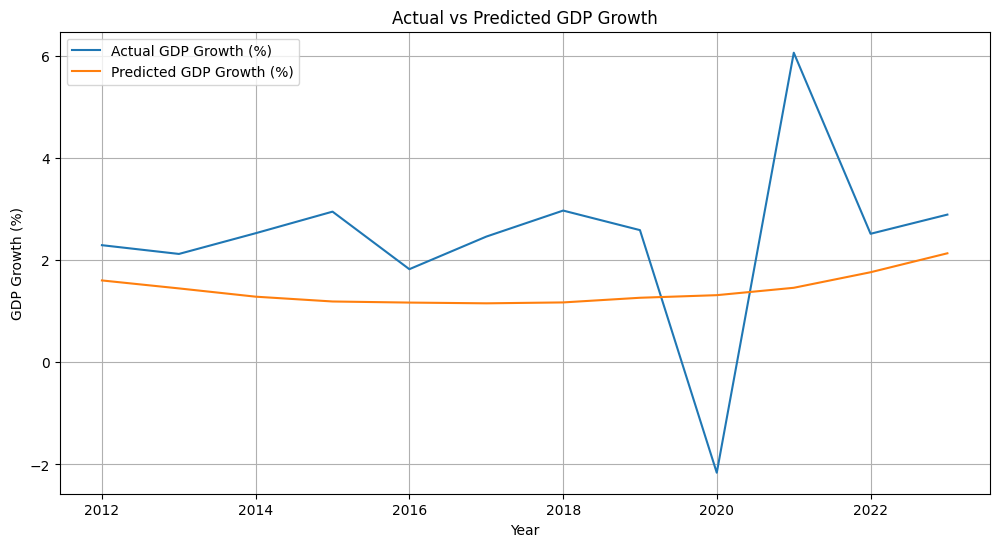

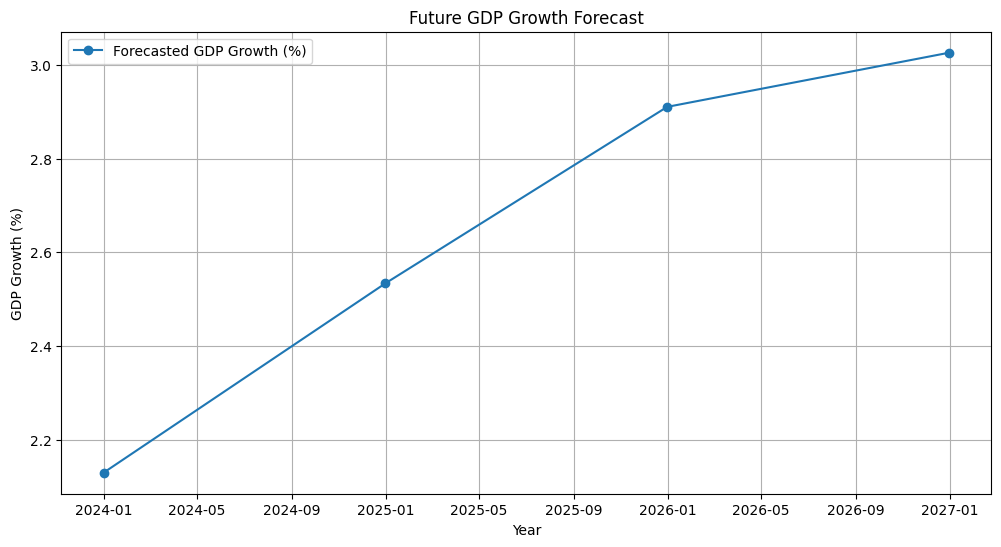

In [5]:
# Main execution
def main():
    # Fetch GDP growth data (annual %)
    indicator = 'NY.GDP.MKTP.KD.ZG'  # GDP growth (annual %)
    print("Fetching GDP growth data from World Bank...")
    gdp_data = fetch_wb_data(indicator)
    if gdp_data is None:
        return

    # Create features
    data_with_features = create_features(gdp_data)

    # Preprocess data
    look_back = 5
    feature_columns = ['value', 'lag_1', 'lag_2', 'rolling_mean', 'rolling_std']
    X_train, y_train, X_test, y_test, scaler = preprocess_data(data_with_features, look_back, feature_columns)

    # Train model
    print("Training LSTM model...")
    model = build_lstm_model(X_train, y_train, look_back, len(feature_columns))

    # Make predictions
    predictions = make_predictions(model, X_test, scaler, feature_columns)
    y_test_scaled = inverse_transform_actual(y_test, scaler, feature_columns)
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))
    print(f"Test RMSE: {rmse:.4f}")

    # Plot actual vs predicted
    test_dates = data_with_features.index[-len(y_test):]
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test_scaled, label="Actual GDP Growth (%)")
    plt.plot(test_dates, predictions, label="Predicted GDP Growth (%)")
    plt.title("Actual vs Predicted GDP Growth")
    plt.xlabel("Year")
    plt.ylabel("GDP Growth (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Forecast future values (4 years ahead)
    future_steps = 4
    last_sequence = X_test[-1]
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(future_steps):
        current_sequence = np.reshape(current_sequence, (1, look_back, len(feature_columns)))
        next_pred = model.predict(current_sequence, verbose=0)
        future_predictions.append(next_pred[0, 0])
        # Shift sequence and append new prediction
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, 0] = next_pred[0, 0]
        # Approximate other features (e.g., lags and rolling stats)
        for i in range(1, len(feature_columns)):
            current_sequence[0, -1, i] = current_sequence[0, -2, i]  # Carry forward last known value

    future_predictions = inverse_transform_actual(np.array(future_predictions), scaler, feature_columns)
    # Generate future dates
    last_date = data_with_features.index[-1]
    future_dates = [last_date + timedelta(days=365 * (i + 1)) for i in range(future_steps)]

    # Plot future forecasts
    plt.figure(figsize=(12, 6))
    plt.plot(future_dates, future_predictions, label="Forecasted GDP Growth (%)", marker='o')
    plt.title("Future GDP Growth Forecast")
    plt.xlabel("Year")
    plt.ylabel("GDP Growth (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
